# Deep Neural Networks for modeling a Combined Cycle Power Plant (CCPP)


The dataset is taken from [UCI data repository](https://archive.ics.uci.edu/ml/datasets/combined+cycle+power+plant). It contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the plant was set to work with full load.

Features consist of hourly average ambient variables:

*   Ambient Temperature (AT)
*   Exhaust Vacuum (V)
*   Ambient Pressure (AP)
*   Relative Humidity (RH)


to predict the net hourly electrical energy output (PE) of the plant.

A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum is colected from and has effect on the Steam Turbine, the other three of the ambient variables affect the GT performance.

The image below and most of this code is taken from [Machine Learning for Process Systems Engineering Ebook](https://leanpub.com/machineLearningPSE)

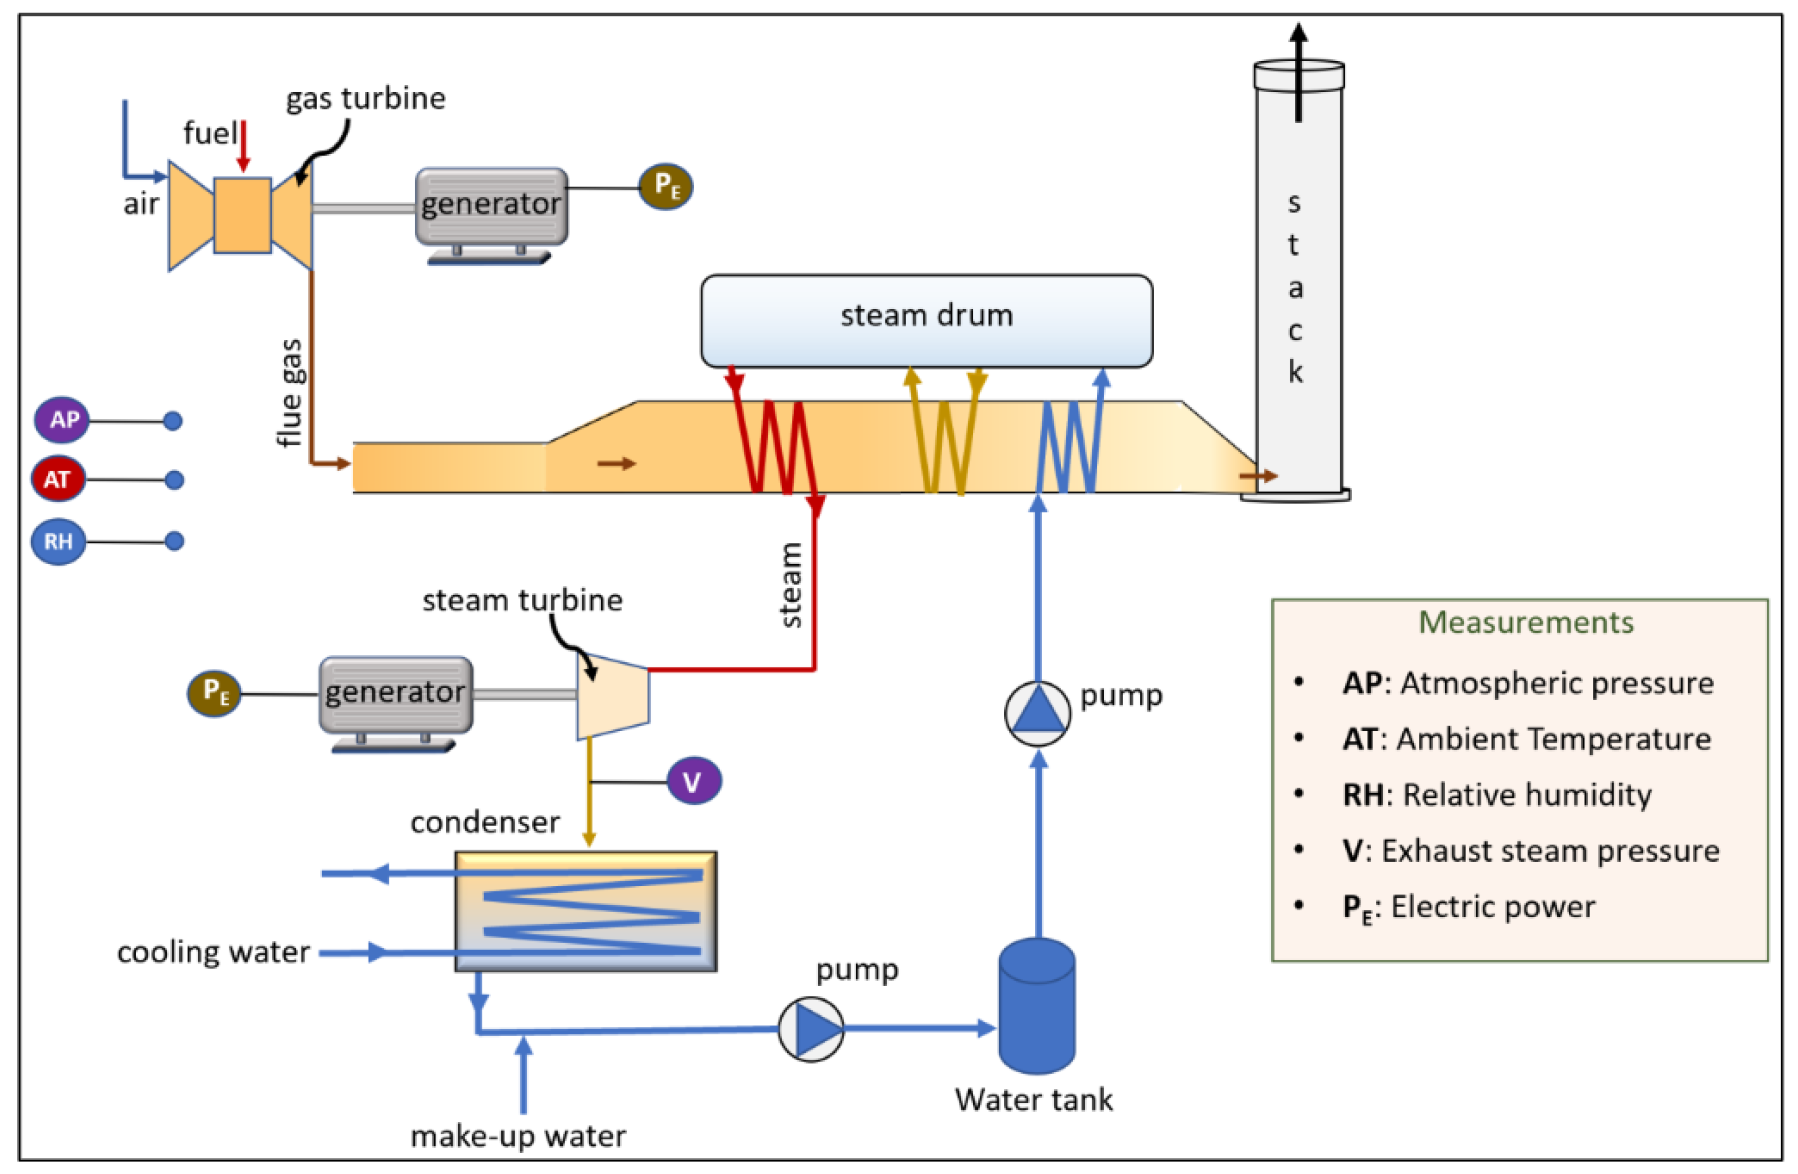

As usual, let's import some libraries and read the data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

In [ ]:
df = pd.read_csv('/content/CCPP_training_data.csv')
df.head()

In [ ]:
df.describe()

Let's look if some values are missing in the dataset.

In [ ]:
df = df[(df['AT'].notna() & df['V'].notna() & df['AP'].notna() & df['RH'].notna() & df['PE'].notna())]
df.shape

### Plot input/output relationaships

Since, we have multiple inputs/features, it make sense (at this step) to **ploting the data** which is always useful. So, let's see what shapes we are dealing with, what trend the data follows.

In [ ]:
plt.figure(figsize=(13, 7))
plt.subplot(221)
plt.plot(df['AT'], df['PE'], 'kx', markersize=3)
plt.xlabel('AT')
plt.ylabel('PE')

plt.subplot(222)
plt.plot(df['V'], df['PE'], 'kx', markersize=3)
plt.xlabel('V')
plt.ylabel('PE')

plt.subplot(223)
plt.plot(df['AP'], df['PE'], 'kx', markersize=3)
plt.xlabel('AP')
plt.ylabel('PE')

plt.subplot(224)
plt.plot(df['RH'], df['PE'], 'kx', markersize=3)
plt.xlabel('RH')
plt.ylabel('PE')

plt.suptitle('Input/Output Relationship', size=15)
plt.show()

To start with, Let's quickly fit a linear model as a baseline...

In [ ]:
df = np.array(df)
#Input
X = df[:,0:4]

#output
y = df[:,4].reshape(-1,1)
y.min(),y.max()

Let's do train/test split

In [ ]:
# Split the complete dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as MAPE
linear_regression = LinearRegression().fit(X_train, y_train)

y_pred_train = linear_regression.predict(X_train)
y_pred_test = linear_regression.predict(X_test)
R2_train = linear_regression.score(X_train, y_pred_train)
R2_test = linear_regression.score(X_test, y_pred_test)
MAPE_train = MAPE(y_train,y_pred_train)
MAPE_test = MAPE(y_test,y_pred_test)
plt.figure()
plt.plot(y_test, y_pred_test, 'co')
plt.plot([400, 500], [400, 500], ls="--", c=".3")
plt.xlabel('Experimental')
plt.ylabel('Predicted')
plt.legend()
print('R2_test :', R2_test)
print('MAPE_test :', MAPE_test)

### Train a Deep Neural Network

Let's now build a 2 hidden-layer neural network using tensorflow.keras with the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation function.

Let's understand how to impelement DNN using tensorflow.keras library

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense, Activation

In [ ]:
model_example = Sequential()
model_example.add(Dense(10, input_shape=(2,), activation='relu'))
model_example.add(Dense(20, activation='relu'))
model_example.add(Dense(1))
model_example.summary()

In [ ]:
# Feed-forward Neural Network model

def FFNN_model(hidden_layers, layer_size, regularizationValue, learningRate):
#layer_size is a list which contains same number of elements as number of hidden layers
    model = Sequential()
    model.add(Dense(layer_size[0], 
                    kernel_regularizer=regularizers.L1(regularizationValue), 
                    activation='relu', 
                    kernel_initializer='he_normal', 
                    input_shape=(4,)))
    
    for i in range(1,hidden_layers):
        model.add(Dense(layer_size[i], 
                        kernel_regularizer=regularizers.L1(regularizationValue), 
                        activation='relu', 
                        kernel_initializer='he_normal'))
        
    model.add(Dense(1))
    model.compile(loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()], optimizer=Adam(learning_rate=learningRate))
    
    return model

We can count the number of trainable model parameters using the following function

In [ ]:
model_dummy = FFNN_model(2, [10,20], 0.001, 0.05)
model_dummy.summary()

In [ ]:
from keras.utils import plot_model
plot_model(model_dummy, to_file = "model.png")

In [ ]:
model = KerasRegressor(build_fn=FFNN_model, epochs=25, batch_size=50,verbose = 0)

In [ ]:
# Split the complete dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# Split the train set into training (estimation) and validation sets
X_est, X_val, y_est, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=100)

In [ ]:
#scaling for cross validation
X_scaler = StandardScaler()

X_est_scaled = X_scaler.fit_transform(X_est)
X_val_scaled = X_scaler.transform(X_val)
X_test_scaled = X_scaler.transform(X_test)

Let's use grid search cross validation for hyperparameter tunning. 
What are the hyperparamters in our model?

In [ ]:
# gridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
param_grid={
    "hidden_layers":[2],
    "layer_size":[[1,1],[2,2],[3,3],[4,4]],
    "regularizationValue": [0.001],
    "learningRate":[0.05]
}

grid_searchcv = GridSearchCV(model, param_grid)
grid_searchcv.fit(X_est_scaled, y_est, validation_data=(X_val_scaled, y_val))

In [ ]:
best_model = grid_searchcv.best_estimator_.model
best_model.summary()

In [ ]:
# predict y_test
y_test_pred = best_model.predict(X_test_scaled)

plt.figure()
plt.plot(y_test, y_test_pred, '*')
plt.plot([410, 500], [410, 500], ls="--", c=".3")
plt.xlabel('y_test')
plt.ylabel('y_test_pred')
print('R2:', r2_score(y_test,y_test_pred))
print('MAPE:', MAPE(y_test,y_pred_test))

Final model by using all available data for training with optimized hyperparameters.

In [ ]:
df = np.array(df)
X = df[:,0:4]
y = df[:,4].reshape(-1,1)

X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X)

In [ ]:
sahil_final_model = FFNN_model(2,[5,5],0.001,0.05)
sahil_final_model.fit(X_scaled, y, epochs=25, batch_size=50) 

How to save the trained model so as to use directly later.

In [ ]:
sahil_final_model.save('sahil_final_model.h5')   # Always save model file with your name so that we can keep track on your files

How you will write the final code (function) after your model training.

In [ ]:
df = np.array(df)
def sahil_model(df):
    X = df[:,0:4]
    y = df[:,4].reshape(-1,1)
    X_scaler = StandardScaler()
    X_scaled = X_scaler.fit_transform(X)
    model = keras.models.load_model('/content/sahil_final_model.h5')
    y_pred = model.predict(X_scaled)
    plt.figure()
    plt.plot(y, y_pred, '*')
    plt.xlabel('y')
    plt.ylabel('y_pred')
    r2 =  r2_score(y, y_pred)
    return r2

How I will check the performance of your model? I have prepared my own function like this

In [ ]:
# df = np.array(df)
# df_test = np.array(df_test)
# def test_model(df,df_test):
#     X = df[:,0:4]
#     X_test = df_test[:,0:4]
#     y = df[:,4].reshape(-1,1)
#     y_test = df_test[:,4].reshape(-1,1)
#     X_scaler = StandardScaler()
#     X_scaled = X_scaler.fit_transform(X)
#     X_test_scaled = X_scaler.transform(X_test)
#     model = keras.models.load_model('/content/sahil_final_model.h5')
#     y_test_pred = model.predict(X_test_scaled)
#     plt.figure()
#     plt.plot(y_test, y_test_pred, '*')
#     plt.xlabel('y')
#     plt.ylabel('y_test_pred')
#     r2_test =  r2_score(y, y_test_pred)
#     return r2_test

How to extract trained model parameters?

In [ ]:
model = keras.models.load_model('/content/sahil_final_model.h5')

In [ ]:
W_Input_Hidden1 = model.layers[0].get_weights()[0]
B_Input_Hidden1 = model.layers[0].get_weights()[1]
W_Hidden1_Hidden2 = model.layers[1].get_weights()[0]
B_Hidden1_Hidden2 = model.layers[1].get_weights()[1]
W_Hidden2_Output = model.layers[2].get_weights()[0]
B_Hidden2_Output = model.layers[2].get_weights()[1]

**Task:**

Try to code forward pass to calcuate y_test_pred using X_test_scaled as inputs and the above extracted weights

In [ ]:
#write your code here

Please note you can also use **Early stopping, different regularizers** during defining the model function (FFNN_model) as defined during today's session.